In [1]:
%matplotlib inline
%load_ext cython
%load_ext autoreload

import matplotlib.pyplot as plt
import numpy as np
from plotting_utils import label_sample, figure_path
import pandas as pd
import glob
import re
import os
from multiprocessing import Pool
import seaborn as sns
from matplotlib import rcParams
from sequencing_tools.viz_tools import color_encoder, okabeito_palette
from sklearn.preprocessing import LabelEncoder
from Bio import SeqUtils

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [2]:
%%cython
from collections import Counter, defaultdict
from operator import itemgetter
import re
from xopen import xopen

sc_re = re.compile('([0-9]+)S')
cdef soft_clip_base(cigar):
    s = sc_re.findall(cigar)
    s = map(int, s)
    return sum(s)

cpdef get_start(sample_folder):
    cdef:
        str line
        str chrom, start, end, strand, cigar
        list fields
        int sstart, send
    
    tRNA_regex = re.compile('^TR[A-Z]-')
    end_loc_counter = defaultdict(Counter)
    bed_file = sample_folder + '/count_temp/small_RNA.bed.gz'
    with xopen(bed_file) as bed:
        for line in bed:
            fields = line.strip().split('\t')
            chrom, start, end, strand, cigar = itemgetter(0,1,2,5, 6)(fields)
            sstart, send = int(start), int(end)
            
            is_tRNA = tRNA_regex.search(chrom)
            is_sense = strand == "+"
            good_alignment = soft_clip_base(cigar) < 10 
            not_fulllength = (send - sstart) < 50
            if is_tRNA and is_sense and good_alignment and not_fulllength:
                end_loc_counter[long(start)][long(end)] += 1
    return end_loc_counter

In [3]:
sample_folders = glob.glob('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/*001')
sample_folders = filter(lambda x: re.search('^[Qq][cC][fF][0-9]+|[qQ][cC][fF]_[pP]hos|[DE][ED]|Exo|[fF]rag', os.path.basename(x)), 
                     sample_folders) 
sample_folders = list(sample_folders)

In [4]:
tablename = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/merged_bam/small_rna/phosphatase.smallRNA.total.nameSorted.tsv.gz'
ldf = pd.read_table(tablename,
             names = ['chrom','start','end','read_count'])\
    .query('end - start < 50')\
    .assign(anticodon = lambda d: d.chrom.str.extract('-([A-Z]{3})-', expand=False))\
    .assign(aa = lambda d: d.chrom.str.extract('(TR[A-Z])',expand=False)) \
    .groupby(['aa','anticodon','start','end'], as_index=False)\
    .agg({'read_count':'sum'}) \
    .assign(anticodon_label = lambda d: d.groupby('aa').anticodon.transform(LabelEncoder().fit_transform))\
    .assign(read_fraction = lambda d: d.groupby('anticodon').read_count.transform(lambda x: x/x.sum()))\
    .assign(color = lambda d: color_encoder().fit_transform(d.anticodon_label))
ldf.head()

,aa,anticodon,start,end,read_count,anticodon_label,read_fraction,color
0,TRA,AGC,0,29,1,0,0.000023,#E69F00
1,TRA,AGC,0,30,14,0,0.000323,#E69F00
2,TRA,AGC,0,35,2,0,0.000046,#E69F00
3,TRA,AGC,0,36,11,0,0.000254,#E69F00
4,TRA,AGC,0,37,38,0,0.000877,#E69F00


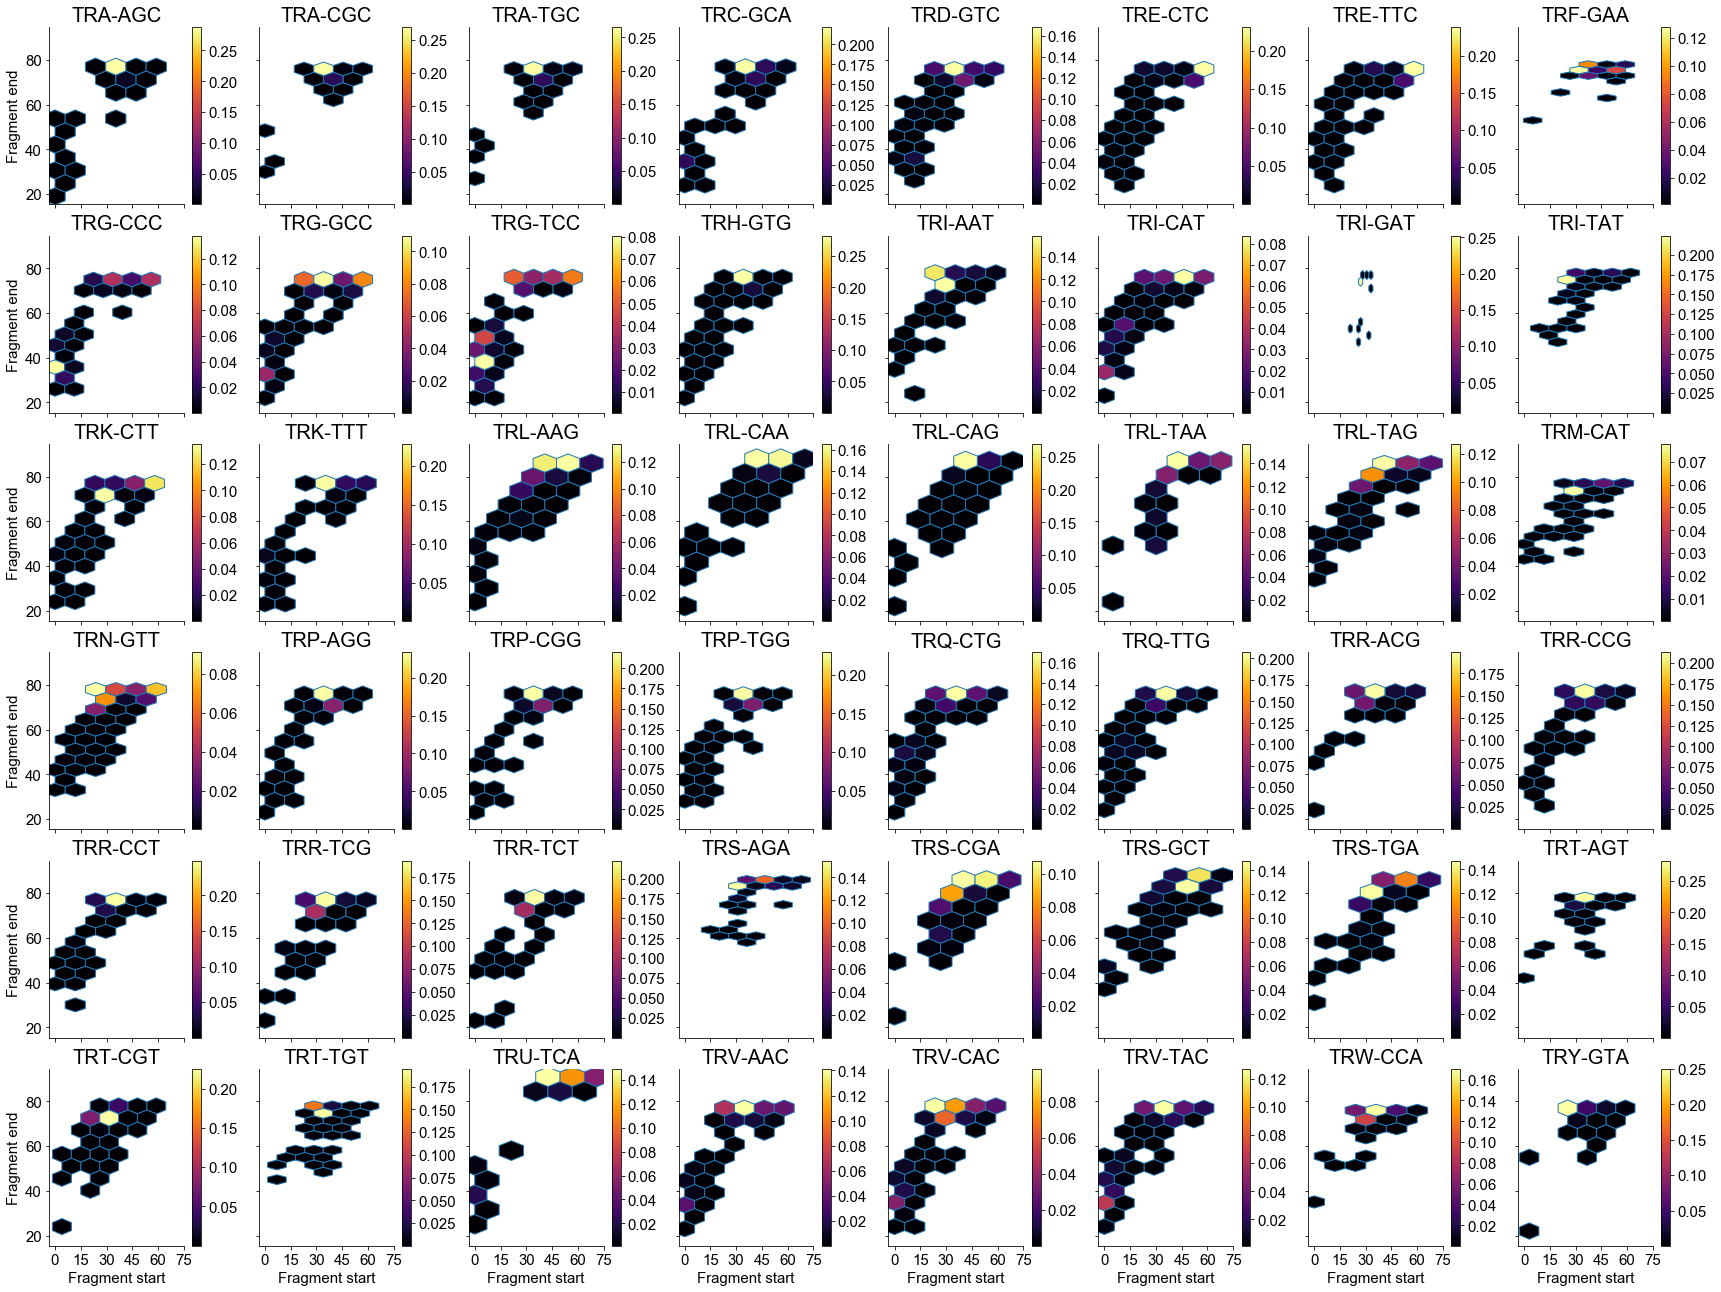

In [5]:
def weighted_hist(x, y, weights, **kwargs):
    hx = plt.hexbin(x = x, y = y, 
                  C = weights,
                  reduce_C_function=np.sum,
                  mincnt = 0, cmap ='inferno', 
                  bins='log', gridsize=(5,5), 
                  **kwargs)
    plt.colorbar(hx)
    
p = sns.FacetGrid(data = ldf.assign(tRNA = lambda d: d.aa + '-' + d.anticodon), 
                  col = 'tRNA', col_wrap=8)
p.map(weighted_hist, 'start', 'end', 'read_fraction')
p.set_titles('{col_name}',size=20)
p.set_axis_labels('Fragment start','Fragment end')
p.set(xticks=np.arange(0,81,15))

In [6]:
df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/tsRNA.feather') \
    .assign(anticodon = lambda d: d.tRNA.str.extract('-([ACTGN]{3})-', expand=False)) \
    .assign(prep = lambda d: d.samplename.map(label_sample))\
    .assign(aa = lambda d: d.tRNA.str.extract('TR([A-Z]+)-', expand=False).map(SeqUtils.seq3))\
    .assign(aa = lambda d: np.where(d.aa == "IleMetGluThr",'iMet',d.aa))\
    .groupby(['anticodon','prep','samplename','frag_type','aa'], as_index=False) \
    .agg({'frag_count':'sum'}) \
    .assign(frag_fraction = lambda d: 100*d.groupby(['samplename','prep','aa','anticodon']).frag_count.transform(lambda x: x/x.sum()))\
    .query('frag_type != "Others"')  \
    .assign(anticodon = lambda d: d.aa +'-'+ d.anticodon) \
    .sort_values('aa')
df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


,anticodon,prep,samplename,frag_type,aa,frag_count,frag_fraction
5356,Ala-TGC,DNase I - 3'P,Qcf_Phos2_R1_001,3' half,Ala,17,0.094787
2462,Ala-CGC,Poly(A)-selected,Qcf_L4_R1_001,3' half,Ala,1,2.325581
2460,Ala-CGC,Poly(A)-selected,Qcf_L3_R1_001,3' tsRNA,Ala,7,6.603774
2454,Ala-CGC,NaOH,Qcf_NA3_R1_001,3' tsRNA,Ala,1,33.333333
2451,Ala-CGC,MNase RNP,PPF10_R1_001,3' tsRNA,Ala,472,1.138831


In [9]:
prep = ['DNase I', "DNase I - 3'P"]
tsRNA = ["3' half", "5' half", "3' tsRNA"]
anticodon = df.anticodon.unique().tolist()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:1418: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


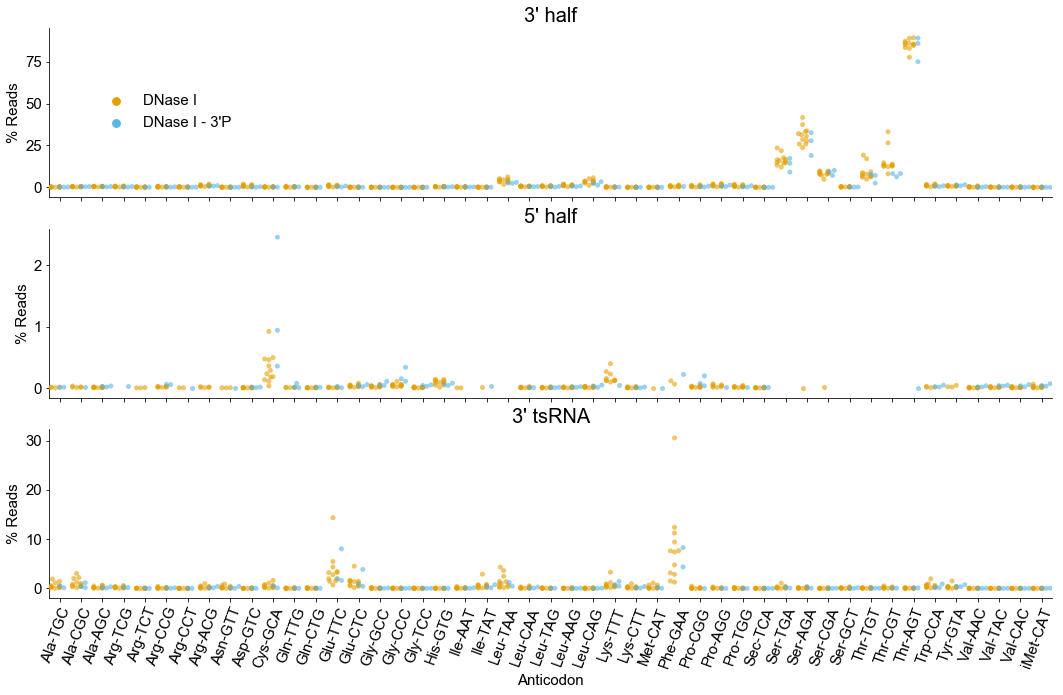

In [10]:
p = sns.FacetGrid(data = df.pipe(lambda d: d[d.prep.isin(prep)]), 
                col = 'frag_type', 
                col_wrap=1, 
                col_order = tsRNA,
                aspect=5,
                sharey=False)
p.map(sns.swarmplot,
      'anticodon',
      'frag_fraction',
      'prep',
      alpha=0.6,
      hue_order = prep,
      order = anticodon,
      palette = okabeito_palette(),
      dodge=True)
for ax in p.fig.axes:
    ax.set_xticklabels(ax.get_xticklabels(),
                      rotation=70,
                      ha = 'right',
                      rotation_mode='anchor')
p.set_titles('{col_name}', size=20)
p.add_legend(fontsize=15, bbox_to_anchor=(0.2,0.9))
p.set_axis_labels('Anticodon', '% Reads')
p.savefig(figure_path + '/tRNA_fragment_percentage.pdf', bbox_inches='tight')